
#Užduotis

####Trečioje užduotyje reikia realizuoti vaizdų segmentavimo modelį.

####Atsiskaitinėjant pratybų dėstytojas atsiųs testinių vaizdų, su kuriais turėsite pademonstruoti, kaip jūsų realizuotas modelis veikia. Atsiskaitymo metu, turėsite gebėti papasakoti, kaip realizuotas jūsų modelis. Programinės įrangos sprendimą galite naudoti savo nuožiūra.
<br>

* Klasės pasirenkamos savo nuožiūra, tačiau jų turi būti bent 3. <br>
* Duomenų rinkinys turi būti padalintas į mokymo ir testavimo aibes.<br>
* Su testavimo duomenų aibe reikia paskaičiuoti šias metrikas: Dice, Micro-F1 ir Macro-F1 statistikas<br> <br>

####Duomenų klasėms parinktos iš OpenImages V6 segmentavimo uždavinio duomenų rinkinio.<br>

<br>PAPILDOMAI: Sukuriant vartotojo sąsają ir modelio iškvietimą per REST API ir interaktyviai atvaizduojant segmentavimo ir prognozių vaizdų kaukes.

In [ ]:
!pip install fiftyone

In [87]:
import fiftyone as fo
import tensorflow as tf
import fiftyone as fo
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow.keras.layers as tfl
import tensorflow.keras.callbacks as tcl
import keras
import cv2
from keras.utils import Sequence
from PIL import Image

In [123]:
# Konstantos ir kintamieji
IMAGE_DIMENSIONS=256
BATCH_SIZE = 16
DIM = 256
CH = 3
EPOCHS=30
classes = ["Bird", "Dog", "Cat"]
BASE_PATH = "/gmm7"
empty_masks = set()
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [124]:
fo.config.dataset_zoo_dir = BASE_PATH

def load_data(image_class, split, sample_size):
    return fo.zoo.load_zoo_dataset(
              "open-images-v7",
              split=split,
              label_types=["segmentations"],
              classes=[image_class],
              seed = 42,
              max_samples=sample_size,
              dataset_name=f"{image_class}-{split}-{sample_size}"
          )

In [ ]:
# Siunčiame duomenys treniravimui ir validacijai

for image_class in classes:
  temp_class_training = load_data(image_class, "train", 10)
  fo.utils.image.transform_images(temp_class_training, size=(IMAGE_DIMENSIONS, IMAGE_DIMENSIONS))
  temp_class_training.save()

  temp_class_validation = load_data(image_class, "validation", 10)
  fo.utils.image.transform_images(temp_class_validation, size=(IMAGE_DIMENSIONS, IMAGE_DIMENSIONS))
  temp_class_validation.save()

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/gmm7/open-images-v7/train' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv' to '/gmm7/open-images-v7/train/metadata/image_ids.csv'


 100% |██████|    4.8Gb/4.8Gb [27.4s elapsed, 0s remaining, 195.5Mb/s]      


INFO:eta.core.utils: 100% |██████|    4.8Gb/4.8Gb [27.4s elapsed, 0s remaining, 195.5Mb/s]      


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/gmm7/open-images-v7/train/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/gmm7/open-images-v7/train/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmpdq_8nl5_/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv' to '/gmm7/open-images-v7/train/labels/segmentations.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-0.zip' to '/gmm7/open-images-v7/train/labels/masks/0.zip'


INFO:fiftyone.utils.openimages:Downloading 10 images


 100% |█████████████████████| 10/10 [4.5s elapsed, 0s remaining, 2.2 files/s]      


INFO:eta.core.utils: 100% |█████████████████████| 10/10 [4.5s elapsed, 0s remaining, 2.2 files/s]      


Dataset info written to '/gmm7/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/gmm7/open-images-v7/info.json'


Loading 'open-images-v7' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'train'


 100% |███████████████████| 10/10 [2.2s elapsed, 0s remaining, 4.5 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 10/10 [2.2s elapsed, 0s remaining, 4.5 samples/s]      


Dataset 'Bird-train-10' created


INFO:fiftyone.zoo.datasets:Dataset 'Bird-train-10' created
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


 100% |███████████████████| 10/10 [984.1ms elapsed, 0s remaining, 10.2 samples/s]     


INFO:eta.core.utils: 100% |███████████████████| 10/10 [984.1ms elapsed, 0s remaining, 10.2 samples/s]     


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/gmm7/open-images-v7/validation' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/validation/validation-images-with-rotation.csv' to '/gmm7/open-images-v7/validation/metadata/image_ids.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/gmm7/open-images-v7/validation/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/gmm7/open-images-v7/validation/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmp1iw8nuk4/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/validation-annotations-object-segmentation.csv' to '/gmm7/open-images-v7/validation/labels/segmentations.csv'


INFO:fiftyone.utils.openimages:Downloading 10 images


 100% |█████████████████████| 10/10 [4.4s elapsed, 0s remaining, 2.3 files/s]      


INFO:eta.core.utils: 100% |█████████████████████| 10/10 [4.4s elapsed, 0s remaining, 2.3 files/s]      


Dataset info written to '/gmm7/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/gmm7/open-images-v7/info.json'


Loading 'open-images-v7' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'validation'


 100% |███████████████████| 10/10 [638.9ms elapsed, 0s remaining, 15.9 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 10/10 [638.9ms elapsed, 0s remaining, 15.9 samples/s]      


Dataset 'Bird-validation-10' created


INFO:fiftyone.zoo.datasets:Dataset 'Bird-validation-10' created
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


 100% |███████████████████| 10/10 [685.6ms elapsed, 0s remaining, 14.6 samples/s]     


INFO:eta.core.utils: 100% |███████████████████| 10/10 [685.6ms elapsed, 0s remaining, 14.6 samples/s]     


INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/gmm7/open-images-v7/train' if necessary


INFO:fiftyone.utils.openimages:Downloading 10 images


 100% |█████████████████████| 10/10 [5.6s elapsed, 0s remaining, 1.8 files/s]    


INFO:eta.core.utils: 100% |█████████████████████| 10/10 [5.6s elapsed, 0s remaining, 1.8 files/s]    


Dataset info written to '/gmm7/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/gmm7/open-images-v7/info.json'


Loading 'open-images-v7' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'train'


 100% |███████████████████| 10/10 [1.1s elapsed, 0s remaining, 9.3 samples/s]         


INFO:eta.core.utils: 100% |███████████████████| 10/10 [1.1s elapsed, 0s remaining, 9.3 samples/s]         


Dataset 'Dog-train-10' created


INFO:fiftyone.zoo.datasets:Dataset 'Dog-train-10' created
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


 100% |███████████████████| 10/10 [813.6ms elapsed, 0s remaining, 12.3 samples/s]     


INFO:eta.core.utils: 100% |███████████████████| 10/10 [813.6ms elapsed, 0s remaining, 12.3 samples/s]     


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/gmm7/open-images-v7/validation' if necessary


INFO:fiftyone.utils.openimages:Downloading 10 images


 100% |█████████████████████| 10/10 [4.5s elapsed, 0s remaining, 2.2 files/s]      


INFO:eta.core.utils: 100% |█████████████████████| 10/10 [4.5s elapsed, 0s remaining, 2.2 files/s]      


Dataset info written to '/gmm7/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/gmm7/open-images-v7/info.json'


Loading 'open-images-v7' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'validation'


 100% |███████████████████| 10/10 [778.3ms elapsed, 0s remaining, 12.8 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 10/10 [778.3ms elapsed, 0s remaining, 12.8 samples/s]      


Dataset 'Dog-validation-10' created


INFO:fiftyone.zoo.datasets:Dataset 'Dog-validation-10' created
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


 100% |███████████████████| 10/10 [716.1ms elapsed, 0s remaining, 14.0 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 10/10 [716.1ms elapsed, 0s remaining, 14.0 samples/s]      


INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/gmm7/open-images-v7/train' if necessary


In [ ]:
# Patikriname ar visi datasetai uzsikrovė

fo.list_datasets()

In [ ]:
# ds = fo.load_dataset("Cat-validation-100")
# fo.launch_app(ds)

In [ ]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

def unet_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    conv1 = conv_block(inputs, 32)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
    drop1 = tf.keras.layers.Dropout(0.2)(pool1)

    conv2 = conv_block(drop1, 64)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    drop2 = tf.keras.layers.Dropout(0.3)(pool2)

    conv3 = conv_block(drop2, 128)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
    drop3 = tf.keras.layers.Dropout(0.4)(pool3)

    conv4 = conv_block(drop3, 256)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)

    up5 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(drop4)
    concat5 = tf.keras.layers.concatenate([up5, conv3], axis=3)
    conv5 = conv_block(concat5, 128)

    up6 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat6 = tf.keras.layers.concatenate([up6, conv2], axis=3)
    conv6 = conv_block(concat6, 64)

    up7 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv1], axis=3)
    conv7 = conv_block(concat7, 32)

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax', dtype=tf.float32)(conv7)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

@keras.saving.register_keras_serializable()
def sparse_categorical_logits(y_true, y_pred):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)

@keras.saving.register_keras_serializable()
def sparse_dice_coeff(y_true, y_pred, smooth=1):
    y_true=tf.cast(y_true, tf.int8)
    y_true = tf.cast(tf.one_hot(y_true, depth=len(classes)+1), y_pred.dtype)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - sparse_dice_coeff(y_true, y_pred)

@keras.saving.register_keras_serializable()
def sparse_categorical_crossentropy(y_true, y_pred, clip=True):
    y_true = tf.convert_to_tensor(tf.cast(y_true, dtype=tf.int32), dtype=tf.int32)
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(tf.one_hot(y_true, depth=len(classes)), y_pred.dtype)

    if clip == True:
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

    return - tf.reduce_mean(tf.math.log(y_pred[y_true == 1]))

def combined_loss(y_true, y_pred):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False) + dice_loss(y_true, y_pred)

model = unet_model((IMAGE_DIMENSIONS, IMAGE_DIMENSIONS, CH), len(classes) + 1)

model.compile(optimizer=tf.keras.optimizers.Adam(epsilon=1e-4), loss=combined_loss, metrics=["accuracy", sparse_dice_coeff])

model.summary()

In [118]:
def pad_mask(mask, box, img):
    x,y,w,h = box
    x*=img.width
    w*=img.width
    y*=img.height
    h*=img.height
    x=np.round(x).astype(int)
    y=np.round(y).astype(int)
    w=np.round(w).astype(int)
    h=np.round(h).astype(int)

    mask = cv2.resize(mask.astype(np.uint8), (w, h))

    t = np.product(img.size) - np.product(mask.shape)
    padded_mask = np.pad(mask, ((y, img.height - y - h), (x, img.width - x - w)), mode='constant', constant_values=(0,0))
    assert np.sum(mask) == np.sum(padded_mask)
    return padded_mask

In [119]:
class FiftyOneDataGenerator(Sequence):
    def __init__(self, dataset, batch_size=BATCH_SIZE, target_size=(IMAGE_DIMENSIONS, IMAGE_DIMENSIONS), shuffle=True, true_length=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.ids = np.array([sample.id for sample in dataset])
        self.counter = 0
        self.true_length = true_length
        print(self.dataset)

    def __len__(self):
        if self.shuffle and self.counter % self.batch_size == 0:
            np.random.shuffle(self.ids)
        self.counter += 1
        return len(self.ids)*EPOCHS if not self.true_length else len(self.ids)

    def __getitem__(self, idx):
        idx = idx % (len(self.ids) // self.batch_size)
        start = idx * self.batch_size
        end = min((idx + 1) * self.batch_size, self.ids.size-1)
        assert start < end, f"start: {start}, end: {end}, idx: {idx}"
        return self.__data_generation(self.ids[start:end])

    def __data_generation(self, arr):
        X = np.zeros((self.batch_size, *self.target_size, 3))
        y = np.zeros((self.batch_size, *self.target_size))

        for i, sample in enumerate([self.dataset[id] for id in arr]):
            image = sample["filepath"]
            image = Image.open(image)
            detections = sample["ground_truth"].detections
            detections = filter(lambda d: d.label in classes, detections)
            label = []
            for d in detections:
                if d.label in classes:
                    label = pad_mask(np.array(d.mask).astype(np.uint8)*(classes.index(d.label)+1), d.bounding_box, image)
                    break
            assert label.shape != np.array([]).shape
            X[i,] = np.array(image) / 255.0
            y[i,] = label
        for idx,i in enumerate(y):
            if np.sum(i) == 0:
                empty_masks.add(arr[idx])
        y=y.astype(np.uint8)
        return X, y

In [ ]:
train_datasets = [fo.load_dataset(f"{cls}-train-100") for cls in classes]
train = train_datasets[0]
for additional_dataset in train_datasets[1:]:
    train.merge_samples(additional_dataset)

test_datasets = [fo.load_dataset(f"{cls}-validation-100") for cls in classes]
test = test_datasets[0]
for additional_dataset in test_datasets[1:]:
    test.merge_samples(additional_dataset)

datagen = FiftyOneDataGenerator(train)
valgen = FiftyOneDataGenerator(test, shuffle=False, true_length=True)

In [121]:
early_stopping = tcl.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode="min", verbose=1)
reduce_lr = tcl.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)

In [ ]:
history = model.fit(
    datagen,
    steps_per_epoch=train.stats()["samples_count"] // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valgen,
    validation_steps=train.stats()["samples_count"] // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)

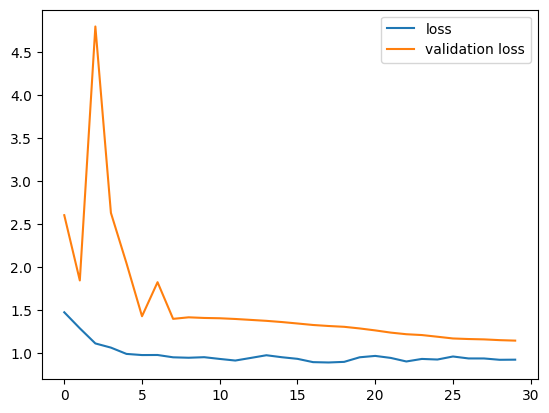

In [69]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

In [70]:
model.save(BASE_PATH + "/models/segment.keras")

1/1 [==============================] - 0s 23ms/step
92.0


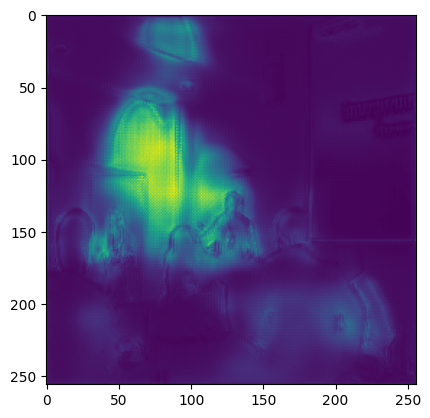

In [71]:
sample = datagen.dataset[datagen.ids[99]]
img = Image.open(sample.filepath)
img=np.array(img)
img=np.expand_dims(img, axis=0)
p=model.predict(img/255.)
plt.imshow(p[0][:,:,1])
print(np.sum(np.round(p[0])[:,:,1]))

In [72]:
model = tf.keras.models.load_model(BASE_PATH + "/models/segment.keras", custom_objects={"sparse_categorical_crossentropy": sparse_categorical_crossentropy, "sparse_dice_coeff": sparse_dice_coeff, "combined_loss": combined_loss})

In [ ]:
p = []
t = []
for i in range(0,300//BATCH_SIZE):
    X,y = valgen.__getitem__(i)
    p.append(model.predict(X))
    t.append(y)

In [75]:
def process_masks(masks):
    max_prob = np.argmax(masks, axis=-1).astype(np.uint8)
    masks_proc = np.zeros_like(masks)
    for i in range(masks.shape[0]):
        for j in range(masks.shape[1]):
            masks_proc[i, j, max_prob[i, j]] = 1
    return np.argmax(masks, axis=-1).astype(np.uint8)

In [ ]:
from sklearn.metrics import f1_score

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

def micro_f1_score(y_true, y_pred):
    return f1_score(y_true.flatten(), y_pred.flatten(), average='micro')

def macro_f1_score(y_true, y_pred):
    return f1_score(y_true.flatten(), y_pred.flatten(), average='macro')


pp = np.array([process_masks(i) for i in p])

dice = dice_coefficient(t, pp)

t = np.array(t)
pp = np.array(pp)

micro_f1 = micro_f1_score(t, pp)
macro_f1 = macro_f1_score(t, pp)

print("Dice coefficient:", dice)
print("Micro-F1 score:", micro_f1)
print("Macro-F1 score:", macro_f1)
